### 作業目的: 透過實作加速版word2vec Skip-gram模型來更加了解高速版的word2vec

本次作業會採用Penn Tree Bank資料及，學員可以在ptb.train.txt中取得訓練文本資料。這次作業可以讓學員練習到以pytorch搭建模型與進行文本資料的前處理

PS: 建議學員使用Colab (或可以使用GPU加速的機器)來進行作業，不然訓練會訓練到天荒地老.....

### Connect to Google Drive

In [2]:
# # Import libraries for importing files from Google drive to Colab
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authorize Google SDK to access Google Drive from Colab

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [22]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#download = drive.CreateFile({'id': '1rNxkeWipGk8BnTvI17SCmq1Z4UcrPxYf'})
#download.GetContentFile('ptb.train.txt')

### Import Necessary Libraries

In [23]:
import os
import re
from tqdm.notebook import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [24]:
# 讀取資料

# Penn Tree Back dataset
with open("./gdrive/My Drive/Colab Notebooks/ptb.train.txt", encoding='utf-8') as f:
    lines = f.readlines()
    
print(f"Total {len(lines)} lines")
raw_dataset = [line.split() for line in lines]

Total 42068 lines


In [25]:
# 查看前5筆
raw_dataset[:5]

[['aer',
  'banknote',
  'berlitz',
  'calloway',
  'centrust',
  'cluett',
  'fromstein',
  'gitano',
  'guterman',
  'hydro-quebec',
  'ipo',
  'kia',
  'memotec',
  'mlx',
  'nahb',
  'punts',
  'rake',
  'regatta',
  'rubens',
  'sim',
  'snack-food',
  'ssangyong',
  'swapo',
  'wachter'],
 ['pierre',
  '<unk>',
  'N',
  'years',
  'old',
  'will',
  'join',
  'the',
  'board',
  'as',
  'a',
  'nonexecutive',
  'director',
  'nov.',
  'N'],
 ['mr.',
  '<unk>',
  'is',
  'chairman',
  'of',
  '<unk>',
  'n.v.',
  'the',
  'dutch',
  'publishing',
  'group'],
 ['rudolph',
  '<unk>',
  'N',
  'years',
  'old',
  'and',
  'former',
  'chairman',
  'of',
  'consolidated',
  'gold',
  'fields',
  'plc',
  'was',
  'named',
  'a',
  'nonexecutive',
  'director',
  'of',
  'this',
  'british',
  'industrial',
  'conglomerate'],
 ['a',
  'form',
  'of',
  'asbestos',
  'once',
  'used',
  'to',
  'make',
  'kent',
  'cigarette',
  'filters',
  'has',
  'caused',
  'a',
  'high',
  'percen

In [26]:
# 定義資料前處理函示
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            # hint: 請計算字詞頻率
            sentence = [word.lower() for word in sentence]
            new_sentence = []
            
            
            if self.only_word:
                pattern = r'[a-z]+'
                for word in sentence:
                    m = re.search(pattern, word)
                    if m is not None:
                        new_sentence.append(m.group())
            else:
                pattern_withpunctuation = r'[a-z.,!?]'
                for word in sentence:
                    m = re.search(pattern_withpunctuation, word)
                    if m is not None:
                        new_sentence.append(m.group())
            
            
            counter.update(new_sentence)
            processed_sentence.append(new_sentence)
                
    
        # hint: 移除頻率過小的字詞 建立word2idx與idx2word與word_frequency辭典
        word_cnt = dict(filter(lambda x:x[1]>self.min_freq, counter.items()))
        self.word2idx = {word:idx for idx, word in enumerate(word_cnt, 0)}
        self.idx2word = {idx:word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in sentence if word in self.word2idx] for sentence in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in sentence if self.subsampling(idx)]for sentence in self.processed_corpus]
            self.total_num_words = sum([len(sentence) for sentence in self.processed_corpus])
            print(f"After subsampling: {self.total_num_words} words")
            counter = Counter([self.idx2word[idx] for sentence in self.processed_corpus for idx in sentence])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
        
        # hint: 移除空句子
        self.processed_corpus = [[idx for idx in sentence] for sentence in self.processed_corpus if len(sentence)!=0 ]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        # hint: 學員可以參考講義的subsampling公式(也可自己定義一個)
        
        p = self.t / self.word_frequency[self.idx2word[idx]] *self.total_num_words
        p_w = math.sqrt(p) + p
        return random.uniform(0, 1) < p_w


# 進行資料前處理
# 這邊我們subsampling的t取1e-4
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(raw_dataset)

Before subsampling: 876414 words
After subsampling: 428971 words


### 定義Skip-gram使用的Dataset與collate function

In [27]:
# 客製化Dataset
class SkipGramGetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # hint: 這裡我們會返回 目標字詞，上下文，負採樣樣本
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []       # 上下文目標
        all_contexts = []      # 文本的一個輸入單字
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            # hint: 這邊我們要創建文本的輸入單字 (考慮window_size)
            for idx in line[self.window_size:-self.window_size]:
                all_contexts.append([idx])
            
            for index in range(self.window_size, len(line) - self.window_size):
                # hint: 創建目標上下文字詞
                indices = list(range(index-self.window_size, index+self.window_size+1))
                indices.remove(index)
                all_targets.append([line[i] for i in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        # hint: 進行負採樣，若沒頭緒的學員可以參考實作範例
        target2freq = dict()
        for target in self.all_targets:
            target = tuple(target)
            target2freq[target] = target2freq.get(target, 0) + 1
        
        cur_exists_target = list(target2freq.keys())
        sampling_weights = [freq**0.75 for target, freq in target2freq.items()]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for j, target in enumerate(self.all_targets):
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=len(cur_exists_target))
                    neg_candidate = list(map(lambda x: cur_exists_target[x], neg_candidate))
                    i = 0
                if neg_candidate[i] != tuple(target):
                    negatives.append(list(neg_candidate[i]))
                i+=1
            all_negatives.append(negatives)
        
        return all_negatives
    
# 客製化collate_fn
def skipgram_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        # hint: 將目標字詞、上下文與負採樣樣本個別打包
        target_negative.append([target]+negative)
        labels.append([1]+[0]*len(negative))
        contexts.append(context)
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

In [28]:
#查看資料產出
d_set = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=1, num_negatives=3)
dataloader = DataLoader(d_set, batch_size=2, shuffle=True, collate_fn=skipgram_collate)

#透過next與iter取出資料
next(iter(dataloader))

(tensor([[182],
         [235]]), tensor([[[1973, 2114],
          [7533, 1735],
          [4245, 2456],
          [8739, 2137]],
 
         [[1036, 7805],
          [ 105, 4116],
          [6562, 1059],
          [  16, 5456]]]), tensor([[1, 0, 0, 0],
         [1, 0, 0, 0]]))

### 定義Skip-gram模型

In [29]:
class SkipGram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(SkipGram, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = self.in_embedding(contexts)
        u = torch.mean(self.out_embedding(targets), dim=2)
        
#         print(v.shape)
#         print(u.shape)
        # do dot product to get output
        pred = torch.matmul(v, u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 訓練

In [30]:
torch.cuda.is_available()

True

In [31]:
# Define hyperparameters

use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01

model = SkipGram(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr) #學員可以自行選用optimizer
dataset = SkipGramGetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=2, num_negatives=5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=skipgram_collate)

In [33]:
# Start training

lst_loss = []
model.train()
for epc in tqdm(range(num_epochs)):
    batch_loss = 0

    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        # hint: 開始訓練前要先將optimizer的梯度歸零
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
#         if i % 500 == 0:
#             print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

Epoch: 1/100, Loss: 1.41337
Epoch: 2/100, Loss: 0.54139
Epoch: 3/100, Loss: 0.34487
Epoch: 4/100, Loss: 0.25823
Epoch: 5/100, Loss: 0.20667
Epoch: 6/100, Loss: 0.16951
Epoch: 7/100, Loss: 0.13999
Epoch: 8/100, Loss: 0.11562
Epoch: 9/100, Loss: 0.09520
Epoch: 10/100, Loss: 0.07814
Epoch: 11/100, Loss: 0.06392
Epoch: 12/100, Loss: 0.05244
Epoch: 13/100, Loss: 0.04290
Epoch: 14/100, Loss: 0.03529
Epoch: 15/100, Loss: 0.02920
Epoch: 16/100, Loss: 0.02451
Epoch: 17/100, Loss: 0.02088
Epoch: 18/100, Loss: 0.01815
Epoch: 19/100, Loss: 0.01612
Epoch: 20/100, Loss: 0.01469
Epoch: 21/100, Loss: 0.01340
Epoch: 22/100, Loss: 0.01252
Epoch: 23/100, Loss: 0.01181
Epoch: 24/100, Loss: 0.01129
Epoch: 25/100, Loss: 0.01102
Epoch: 26/100, Loss: 0.01057
Epoch: 27/100, Loss: 0.01061
Epoch: 28/100, Loss: 0.01020
Epoch: 29/100, Loss: 0.00977
Epoch: 30/100, Loss: 0.00923
Epoch: 31/100, Loss: 0.00892
Epoch: 32/100, Loss: 0.00854
Epoch: 33/100, Loss: 0.00856
Epoch: 34/100, Loss: 0.00815
Epoch: 35/100, Loss: 0.

In [ ]:
# Start training

# lst_loss = []
# model.train()
# for epc in tqdm.tqdm(range(num_epochs)):
#     batch_loss = 0

#     for i, (contexts, target_negative, labels) in enumerate(loader, 1):
#         # hint: 開始訓練前要先將optimizer的梯度歸零
        
#         ### <your code> ###
        
#         if use_cuda:
#             ### <your code> ###
        
#         pred = ### <your code> ###
#         loss = ### <your code> ###
#         batch_loss += loss.item()
#         loss.backward()
#         optimizer.step()
        
#         if i % 500 == 0:
#             print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
#     if verbose:
#         print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
#     lst_loss.append(batch_loss/i)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100, Batch: 501/715.900390625 Loss: 1.05744


  1%|          | 1/100 [00:02<03:51,  2.34s/it]

Epoch: 1/100, Loss: 0.92186
Epoch: 2/100, Batch: 501/715.900390625 Loss: 0.55346


  2%|▏         | 2/100 [00:04<03:43,  2.28s/it]

Epoch: 2/100, Loss: 0.55015
Epoch: 3/100, Batch: 501/715.900390625 Loss: 0.52754


  3%|▎         | 3/100 [00:06<03:39,  2.27s/it]

Epoch: 3/100, Loss: 0.52725
Epoch: 4/100, Batch: 501/715.900390625 Loss: 0.51811


  4%|▍         | 4/100 [00:08<03:33,  2.22s/it]

Epoch: 4/100, Loss: 0.51852
Epoch: 5/100, Batch: 501/715.900390625 Loss: 0.51259


  5%|▌         | 5/100 [00:11<03:34,  2.25s/it]

Epoch: 5/100, Loss: 0.51321
Epoch: 6/100, Batch: 501/715.900390625 Loss: 0.50900


  6%|▌         | 6/100 [00:13<03:33,  2.27s/it]

Epoch: 6/100, Loss: 0.50949
Epoch: 7/100, Batch: 501/715.900390625 Loss: 0.50621


  7%|▋         | 7/100 [00:15<03:26,  2.22s/it]

Epoch: 7/100, Loss: 0.50693
Epoch: 8/100, Batch: 501/715.900390625 Loss: 0.50430


  8%|▊         | 8/100 [00:17<03:20,  2.18s/it]

Epoch: 8/100, Loss: 0.50504
Epoch: 9/100, Batch: 501/715.900390625 Loss: 0.50258


  9%|▉         | 9/100 [00:19<03:21,  2.21s/it]

Epoch: 9/100, Loss: 0.50363
Epoch: 10/100, Batch: 501/715.900390625 Loss: 0.50150


 10%|█         | 10/100 [00:22<03:15,  2.18s/it]

Epoch: 10/100, Loss: 0.50275
Epoch: 11/100, Batch: 501/715.900390625 Loss: 0.50085


 11%|█         | 11/100 [00:24<03:12,  2.16s/it]

Epoch: 11/100, Loss: 0.50200
Epoch: 12/100, Batch: 501/715.900390625 Loss: 0.50052


 12%|█▏        | 12/100 [00:26<03:12,  2.19s/it]

Epoch: 12/100, Loss: 0.50164
Epoch: 13/100, Batch: 501/715.900390625 Loss: 0.50018


 13%|█▎        | 13/100 [00:28<03:08,  2.16s/it]

Epoch: 13/100, Loss: 0.50131
Epoch: 14/100, Batch: 501/715.900390625 Loss: 0.50011


 14%|█▍        | 14/100 [00:30<03:04,  2.15s/it]

Epoch: 14/100, Loss: 0.50111
Epoch: 15/100, Batch: 501/715.900390625 Loss: 0.49991


 15%|█▌        | 15/100 [00:32<03:07,  2.20s/it]

Epoch: 15/100, Loss: 0.50087
Epoch: 16/100, Batch: 501/715.900390625 Loss: 0.49975


 16%|█▌        | 16/100 [00:35<03:02,  2.17s/it]

Epoch: 16/100, Loss: 0.50065
Epoch: 17/100, Batch: 501/715.900390625 Loss: 0.49984


 17%|█▋        | 17/100 [00:37<02:57,  2.14s/it]

Epoch: 17/100, Loss: 0.50059
Epoch: 18/100, Batch: 501/715.900390625 Loss: 0.49951


 18%|█▊        | 18/100 [00:39<02:58,  2.18s/it]

Epoch: 18/100, Loss: 0.50043
Epoch: 19/100, Batch: 501/715.900390625 Loss: 0.49927


 19%|█▉        | 19/100 [00:41<02:54,  2.15s/it]

Epoch: 19/100, Loss: 0.50029
Epoch: 20/100, Batch: 501/715.900390625 Loss: 0.49868


 20%|██        | 20/100 [00:43<02:50,  2.13s/it]

Epoch: 20/100, Loss: 0.50012
Epoch: 21/100, Batch: 501/715.900390625 Loss: 0.49861


 21%|██        | 21/100 [00:45<02:52,  2.18s/it]

Epoch: 21/100, Loss: 0.50000
Epoch: 22/100, Batch: 501/715.900390625 Loss: 0.49861


 22%|██▏       | 22/100 [00:47<02:47,  2.15s/it]

Epoch: 22/100, Loss: 0.49999
Epoch: 23/100, Batch: 501/715.900390625 Loss: 0.49870


 23%|██▎       | 23/100 [00:50<02:47,  2.17s/it]

Epoch: 23/100, Loss: 0.49994
Epoch: 24/100, Batch: 501/715.900390625 Loss: 0.49904


 24%|██▍       | 24/100 [00:52<02:42,  2.13s/it]

Epoch: 24/100, Loss: 0.49985
Epoch: 25/100, Batch: 501/715.900390625 Loss: 0.49885


 25%|██▌       | 25/100 [00:54<02:43,  2.18s/it]

Epoch: 25/100, Loss: 0.49992
Epoch: 26/100, Batch: 501/715.900390625 Loss: 0.49906


 26%|██▌       | 26/100 [00:56<02:38,  2.15s/it]

Epoch: 26/100, Loss: 0.49983
Epoch: 27/100, Batch: 501/715.900390625 Loss: 0.49881


 27%|██▋       | 27/100 [00:58<02:37,  2.16s/it]

Epoch: 27/100, Loss: 0.49972
Epoch: 28/100, Batch: 501/715.900390625 Loss: 0.49846


 28%|██▊       | 28/100 [01:01<02:38,  2.20s/it]

Epoch: 28/100, Loss: 0.49966
Epoch: 29/100, Batch: 501/715.900390625 Loss: 0.49889


 29%|██▉       | 29/100 [01:03<02:35,  2.19s/it]

Epoch: 29/100, Loss: 0.49968
Epoch: 30/100, Batch: 501/715.900390625 Loss: 0.49847


 30%|███       | 30/100 [01:05<02:32,  2.18s/it]

Epoch: 30/100, Loss: 0.49968
Epoch: 31/100, Batch: 501/715.900390625 Loss: 0.49857


 31%|███       | 31/100 [01:07<02:33,  2.22s/it]

Epoch: 31/100, Loss: 0.49964
Epoch: 32/100, Batch: 501/715.900390625 Loss: 0.49833


 32%|███▏      | 32/100 [01:09<02:29,  2.19s/it]

Epoch: 32/100, Loss: 0.49959
Epoch: 33/100, Batch: 501/715.900390625 Loss: 0.49836


 33%|███▎      | 33/100 [01:12<02:26,  2.19s/it]

Epoch: 33/100, Loss: 0.49948
Epoch: 34/100, Batch: 501/715.900390625 Loss: 0.49889


 34%|███▍      | 34/100 [01:14<02:28,  2.25s/it]

Epoch: 34/100, Loss: 0.49949
Epoch: 35/100, Batch: 501/715.900390625 Loss: 0.49865


 35%|███▌      | 35/100 [01:16<02:23,  2.21s/it]

Epoch: 35/100, Loss: 0.49945
Epoch: 36/100, Batch: 501/715.900390625 Loss: 0.49856


 36%|███▌      | 36/100 [01:18<02:19,  2.18s/it]

Epoch: 36/100, Loss: 0.49947
Epoch: 37/100, Batch: 501/715.900390625 Loss: 0.49827


 37%|███▋      | 37/100 [01:20<02:20,  2.22s/it]

Epoch: 37/100, Loss: 0.49938
Epoch: 38/100, Batch: 501/715.900390625 Loss: 0.49820


 38%|███▊      | 38/100 [01:23<02:15,  2.19s/it]

Epoch: 38/100, Loss: 0.49939
Epoch: 39/100, Batch: 501/715.900390625 Loss: 0.49815


 39%|███▉      | 39/100 [01:25<02:12,  2.18s/it]

Epoch: 39/100, Loss: 0.49942
Epoch: 40/100, Batch: 501/715.900390625 Loss: 0.49845


 40%|████      | 40/100 [01:27<02:12,  2.20s/it]

Epoch: 40/100, Loss: 0.49938
Epoch: 41/100, Batch: 501/715.900390625 Loss: 0.49821


 41%|████      | 41/100 [01:29<02:07,  2.16s/it]

Epoch: 41/100, Loss: 0.49929
Epoch: 42/100, Batch: 501/715.900390625 Loss: 0.49841


 42%|████▏     | 42/100 [01:31<02:06,  2.18s/it]

Epoch: 42/100, Loss: 0.49931
Epoch: 43/100, Batch: 501/715.900390625 Loss: 0.49820


 43%|████▎     | 43/100 [01:33<02:04,  2.19s/it]

Epoch: 43/100, Loss: 0.49922
Epoch: 44/100, Batch: 501/715.900390625 Loss: 0.49812


 44%|████▍     | 44/100 [01:36<02:04,  2.22s/it]

Epoch: 44/100, Loss: 0.49929
Epoch: 45/100, Batch: 501/715.900390625 Loss: 0.49817


 45%|████▌     | 45/100 [01:38<02:00,  2.18s/it]

Epoch: 45/100, Loss: 0.49923
Epoch: 46/100, Batch: 501/715.900390625 Loss: 0.49808


 46%|████▌     | 46/100 [01:40<01:56,  2.15s/it]

Epoch: 46/100, Loss: 0.49923
Epoch: 47/100, Batch: 501/715.900390625 Loss: 0.49797


 47%|████▋     | 47/100 [01:42<01:55,  2.18s/it]

Epoch: 47/100, Loss: 0.49931
Epoch: 48/100, Batch: 501/715.900390625 Loss: 0.49821


 48%|████▊     | 48/100 [01:44<01:52,  2.16s/it]

Epoch: 48/100, Loss: 0.49915
Epoch: 49/100, Batch: 501/715.900390625 Loss: 0.49843


 49%|████▉     | 49/100 [01:46<01:48,  2.13s/it]

Epoch: 49/100, Loss: 0.49922
Epoch: 50/100, Batch: 501/715.900390625 Loss: 0.49797


 50%|█████     | 50/100 [01:49<01:48,  2.16s/it]

Epoch: 50/100, Loss: 0.49914
Epoch: 51/100, Batch: 501/715.900390625 Loss: 0.49800


 51%|█████     | 51/100 [01:51<01:44,  2.14s/it]

Epoch: 51/100, Loss: 0.49923
Epoch: 52/100, Batch: 501/715.900390625 Loss: 0.49794


 52%|█████▏    | 52/100 [01:53<01:42,  2.15s/it]

Epoch: 52/100, Loss: 0.49921
Epoch: 53/100, Batch: 501/715.900390625 Loss: 0.49806


 53%|█████▎    | 53/100 [01:55<01:42,  2.17s/it]

Epoch: 53/100, Loss: 0.49913
Epoch: 54/100, Batch: 501/715.900390625 Loss: 0.49832


 54%|█████▍    | 54/100 [01:57<01:38,  2.14s/it]

Epoch: 54/100, Loss: 0.49912
Epoch: 55/100, Batch: 501/715.900390625 Loss: 0.49767


 55%|█████▌    | 55/100 [01:59<01:35,  2.13s/it]

Epoch: 55/100, Loss: 0.49916
Epoch: 56/100, Batch: 501/715.900390625 Loss: 0.49798


 56%|█████▌    | 56/100 [02:01<01:35,  2.16s/it]

Epoch: 56/100, Loss: 0.49902
Epoch: 57/100, Batch: 501/715.900390625 Loss: 0.49789


 57%|█████▋    | 57/100 [02:04<01:32,  2.15s/it]

Epoch: 57/100, Loss: 0.49909
Epoch: 58/100, Batch: 501/715.900390625 Loss: 0.49810


 58%|█████▊    | 58/100 [02:06<01:29,  2.14s/it]

Epoch: 58/100, Loss: 0.49908
Epoch: 59/100, Batch: 501/715.900390625 Loss: 0.49815


 59%|█████▉    | 59/100 [02:08<01:28,  2.17s/it]

Epoch: 59/100, Loss: 0.49912
Epoch: 60/100, Batch: 501/715.900390625 Loss: 0.49804


 60%|██████    | 60/100 [02:10<01:25,  2.14s/it]

Epoch: 60/100, Loss: 0.49910
Epoch: 61/100, Batch: 501/715.900390625 Loss: 0.49820


 61%|██████    | 61/100 [02:12<01:22,  2.12s/it]

Epoch: 61/100, Loss: 0.49907
Epoch: 62/100, Batch: 501/715.900390625 Loss: 0.49785


 62%|██████▏   | 62/100 [02:14<01:22,  2.17s/it]

Epoch: 62/100, Loss: 0.49905
Epoch: 63/100, Batch: 501/715.900390625 Loss: 0.49801


 63%|██████▎   | 63/100 [02:16<01:19,  2.15s/it]

Epoch: 63/100, Loss: 0.49910
Epoch: 64/100, Batch: 501/715.900390625 Loss: 0.49799


 64%|██████▍   | 64/100 [02:19<01:16,  2.13s/it]

Epoch: 64/100, Loss: 0.49903
Epoch: 65/100, Batch: 501/715.900390625 Loss: 0.49827


 65%|██████▌   | 65/100 [02:21<01:14,  2.12s/it]

Epoch: 65/100, Loss: 0.49902
Epoch: 66/100, Batch: 501/715.900390625 Loss: 0.49774


 66%|██████▌   | 66/100 [02:23<01:14,  2.18s/it]

Epoch: 66/100, Loss: 0.49899
Epoch: 67/100, Batch: 501/715.900390625 Loss: 0.49813


 67%|██████▋   | 67/100 [02:25<01:11,  2.17s/it]

Epoch: 67/100, Loss: 0.49904
Epoch: 68/100, Batch: 501/715.900390625 Loss: 0.49812


 68%|██████▊   | 68/100 [02:27<01:08,  2.15s/it]

Epoch: 68/100, Loss: 0.49906
Epoch: 69/100, Batch: 501/715.900390625 Loss: 0.49797


 69%|██████▉   | 69/100 [02:30<01:08,  2.20s/it]

Epoch: 69/100, Loss: 0.49901
Epoch: 70/100, Batch: 501/715.900390625 Loss: 0.49804


 70%|███████   | 70/100 [02:32<01:06,  2.22s/it]

Epoch: 70/100, Loss: 0.49899
Epoch: 71/100, Batch: 501/715.900390625 Loss: 0.49778


 71%|███████   | 71/100 [02:34<01:04,  2.21s/it]

Epoch: 71/100, Loss: 0.49890
Epoch: 72/100, Batch: 501/715.900390625 Loss: 0.49829


 72%|███████▏  | 72/100 [02:36<01:03,  2.26s/it]

Epoch: 72/100, Loss: 0.49907
Epoch: 73/100, Batch: 501/715.900390625 Loss: 0.49815


 73%|███████▎  | 73/100 [02:39<01:01,  2.26s/it]

Epoch: 73/100, Loss: 0.49894
Epoch: 74/100, Batch: 501/715.900390625 Loss: 0.49768


 74%|███████▍  | 74/100 [02:41<00:58,  2.26s/it]

Epoch: 74/100, Loss: 0.49893
Epoch: 75/100, Batch: 501/715.900390625 Loss: 0.49777


 75%|███████▌  | 75/100 [02:43<00:56,  2.26s/it]

Epoch: 75/100, Loss: 0.49896
Epoch: 76/100, Batch: 501/715.900390625 Loss: 0.49793


 76%|███████▌  | 76/100 [02:45<00:53,  2.22s/it]

Epoch: 76/100, Loss: 0.49893
Epoch: 77/100, Batch: 501/715.900390625 Loss: 0.49772


 77%|███████▋  | 77/100 [02:47<00:50,  2.19s/it]

Epoch: 77/100, Loss: 0.49894
Epoch: 78/100, Batch: 501/715.900390625 Loss: 0.49782


 78%|███████▊  | 78/100 [02:50<00:49,  2.27s/it]

Epoch: 78/100, Loss: 0.49886
Epoch: 79/100, Batch: 501/715.900390625 Loss: 0.49785


 79%|███████▉  | 79/100 [02:52<00:46,  2.23s/it]

Epoch: 79/100, Loss: 0.49894
Epoch: 80/100, Batch: 501/715.900390625 Loss: 0.49772


 80%|████████  | 80/100 [02:54<00:43,  2.19s/it]

Epoch: 80/100, Loss: 0.49890
Epoch: 81/100, Batch: 501/715.900390625 Loss: 0.49803


 81%|████████  | 81/100 [02:56<00:42,  2.25s/it]

Epoch: 81/100, Loss: 0.49899
Epoch: 82/100, Batch: 501/715.900390625 Loss: 0.49771


 82%|████████▏ | 82/100 [02:59<00:39,  2.21s/it]

Epoch: 82/100, Loss: 0.49892
Epoch: 83/100, Batch: 501/715.900390625 Loss: 0.49785


 83%|████████▎ | 83/100 [03:01<00:37,  2.20s/it]

Epoch: 83/100, Loss: 0.49898
Epoch: 84/100, Batch: 501/715.900390625 Loss: 0.49766


 84%|████████▍ | 84/100 [03:03<00:35,  2.23s/it]

Epoch: 84/100, Loss: 0.49889
Epoch: 85/100, Batch: 501/715.900390625 Loss: 0.49806


 85%|████████▌ | 85/100 [03:05<00:33,  2.25s/it]

Epoch: 85/100, Loss: 0.49894
Epoch: 86/100, Batch: 501/715.900390625 Loss: 0.49808


 86%|████████▌ | 86/100 [03:07<00:30,  2.21s/it]

Epoch: 86/100, Loss: 0.49894
Epoch: 87/100, Batch: 501/715.900390625 Loss: 0.49790


 87%|████████▋ | 87/100 [03:10<00:28,  2.17s/it]

Epoch: 87/100, Loss: 0.49890
Epoch: 88/100, Batch: 501/715.900390625 Loss: 0.49794


 88%|████████▊ | 88/100 [03:12<00:26,  2.18s/it]

Epoch: 88/100, Loss: 0.49889
Epoch: 89/100, Batch: 501/715.900390625 Loss: 0.49799


 89%|████████▉ | 89/100 [03:14<00:24,  2.20s/it]

Epoch: 89/100, Loss: 0.49887
Epoch: 90/100, Batch: 501/715.900390625 Loss: 0.49843


 90%|█████████ | 90/100 [03:16<00:21,  2.16s/it]

Epoch: 90/100, Loss: 0.49897
Epoch: 91/100, Batch: 501/715.900390625 Loss: 0.49803


 91%|█████████ | 91/100 [03:18<00:19,  2.20s/it]

Epoch: 91/100, Loss: 0.49893
Epoch: 92/100, Batch: 501/715.900390625 Loss: 0.49793


 92%|█████████▏| 92/100 [03:20<00:17,  2.18s/it]

Epoch: 92/100, Loss: 0.49884
Epoch: 93/100, Batch: 501/715.900390625 Loss: 0.49789


 93%|█████████▎| 93/100 [03:23<00:15,  2.20s/it]

Epoch: 93/100, Loss: 0.49892
Epoch: 94/100, Batch: 501/715.900390625 Loss: 0.49790


 94%|█████████▍| 94/100 [03:25<00:13,  2.22s/it]

Epoch: 94/100, Loss: 0.49883
Epoch: 95/100, Batch: 501/715.900390625 Loss: 0.49787


 95%|█████████▌| 95/100 [03:27<00:11,  2.20s/it]

Epoch: 95/100, Loss: 0.49895
Epoch: 96/100, Batch: 501/715.900390625 Loss: 0.49816


 96%|█████████▌| 96/100 [03:29<00:08,  2.19s/it]

Epoch: 96/100, Loss: 0.49890
Epoch: 97/100, Batch: 501/715.900390625 Loss: 0.49785


 97%|█████████▋| 97/100 [03:32<00:06,  2.23s/it]

Epoch: 97/100, Loss: 0.49891
Epoch: 98/100, Batch: 501/715.900390625 Loss: 0.49778


 98%|█████████▊| 98/100 [03:34<00:04,  2.19s/it]

Epoch: 98/100, Loss: 0.49884
Epoch: 99/100, Batch: 501/715.900390625 Loss: 0.49746


 99%|█████████▉| 99/100 [03:36<00:02,  2.16s/it]

Epoch: 99/100, Loss: 0.49891
Epoch: 100/100, Batch: 501/715.900390625 Loss: 0.49763


100%|██████████| 100/100 [03:38<00:00,  2.19s/it]

Epoch: 100/100, Loss: 0.49883


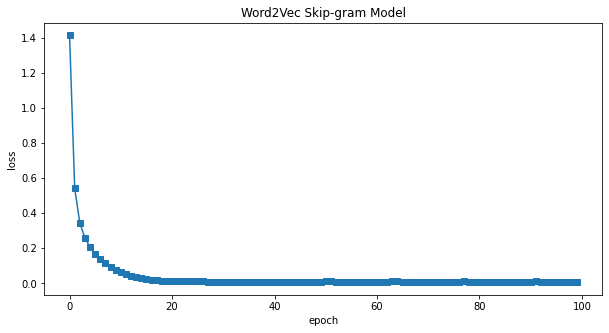

In [34]:
# visualization loss

plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-gram Model')
plt.show()

In [35]:
#計算字詞相似度

def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.394: mystery.
cosine sim=0.370: cold.
cosine sim=0.352: hate.
cosine sim=0.349: authorities.
